C:\Users\91938\anaconda3\envs\finesse\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


90.09009009009009


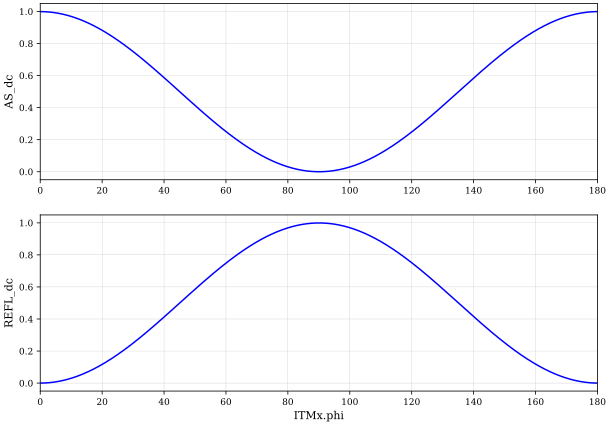

In [1]:
#Modelling the MI first!
import finesse
import numpy as np
import matplotlib.pyplot as plt
finesse.configure(plotting=True)
mi=finesse.Model()
mi.parse("""
l laser P=1
s s0 laser.p1 eom.p1 
mod eom midx=0.4 order=1 f=45M

s s1 eom.p2 Bs.p1 L=0
bs Bs R=0.5 T=0.5 alpha=45  

#X-arm
s Lx Bs.p3 ITMx.p1 
m ITMx R=1 T=0 

#Y-arm
s Ly Bs.p2 ITMy.p1
m ITMy R=1 T=0 

pd AS_dc Bs.p4.o 
pd REFL_dc Bs.p1.o
xaxis(ITMx.phi,lin,0,180,1000)

""")
out=mi.run()
AS_dc=[]
REFL_dc=[]

phi=np.linspace(0,180,1000)
for i in range(1000):
    AS_dc.append(out["AS_dc"][i])
    REFL_dc.append(out["REFL_dc"][i])
fig,plots=plt.subplots(2,figsize=(10,7))
plots[0].plot(phi,AS_dc)
plots[0].set_ylabel("AS_dc")
plots[1].plot(phi,REFL_dc)
plots[1].set_ylabel("REFL_dc")
plots[1].set_xlabel("ITMx.phi")

print(phi[AS_dc.index(min(AS_dc))])    

#### The AS will be dark for the C in the MI at ITMx.phi=90
#### PRM is added to the MI, with random lengths.

In [71]:
# prmi=mi.deepcopy()
# prmi.remove("s1")
# prmi.parse("""
# s s1 eom.p2 prm.p1 L=0
# m prm R=0.85 T=0.15
# s pr_Bs prm.p2 Bs.p1 L=3 """)
# prmi.Lx.L=5
# prmi.Ly.L=5
# prmi.ITMx.phi=90 
### This showed an exception, the m and pr_bs definitions are added to the end of the katscript, it is not
### recognised. I'll see what i can do, for now I will create another model, migrating from MI to PRMI.

89.90990990990991
-89.90990990990991
Width for 2 dark fringes at the AS port: -179.81981981981983


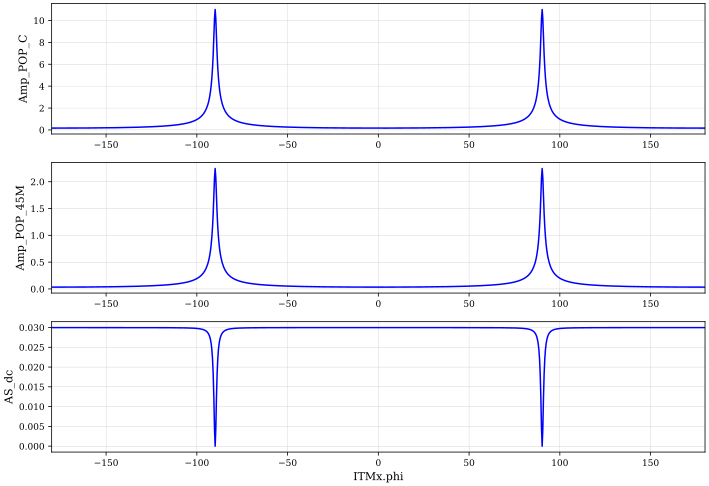

In [20]:
prmi=finesse.Model()
prmi.parse("""
l laser P=1
s s0 laser.p1 eom.p1 L=0
mod eom midx=0.4 order=1 f=45M

#PRM
s s1 eom.p2 prm.p1 L=0
m prm R=0.97 T=0.03 
s pr_Bs prm.p2 Bs.p1

bs Bs R=0.5 T=0.5 alpha=45

#X-arm
s Lx Bs.p3 ITMx.p1
m ITMx R=1 T=0

#Y-arm
s Ly Bs.p2 ITMy.p1
m ITMy R=1 T=0

pd AS_dc Bs.p4.o 
pd REFL_dc prm.p1.o
pd POP_dc prm.p2.o

ad POP_C prm.p2.o f=0
ad POP_45M prm.p2.o f=45M
ad AS_C Bs.p4.o f=0
ad AS_45M Bs.p4.o f=45M
ad REFL_C prm.p1.o f=0
ad REFL_45M prm.p1.o f=45M

xaxis(ITMx.phi,lin,-180,180,1000)

""")
output=prmi.run()
Amp_POP_C=[]
Amp_POP_45M=[]
AS_dc=[]
phi=np.linspace(-180,180,1000)
for i in range(1000):
    Amp_POP_C.append(abs(output["POP_C"][i]))
    Amp_POP_45M.append(abs(output["POP_45M"][i]))
    AS_dc.append(abs(output["AS_dc"][i]))
import matplotlib.pyplot as plt
fig,plots=plt.subplots(3,figsize=(10,7))
plots[0].plot(phi,Amp_POP_C)
plots[0].set_ylabel("Amp_POP_C")
plots[1].plot(phi,Amp_POP_45M)
plots[1].set_ylabel("Amp_POP_45M")
plots[2].plot(phi,AS_dc)
plots[2].set_ylabel("AS_dc")
plots[2].set_xlabel("ITMx.phi")
fig.tight_layout()
#Finding the optimum ITMx.phi for setting the AS dark
opt_ITMx_phi_1=phi[AS_dc.index(min(AS_dc))]
AS_dc.remove(min(AS_dc))
opt_ITMx_phi_2=phi[AS_dc.index(min(AS_dc))]
width=opt_ITMx_phi_1-opt_ITMx_phi_2

print(opt_ITMx_phi_2)
print(opt_ITMx_phi_1)
print("Width for 2 dark fringes at the AS port:",width)

In [50]:
lx=4.5  #Setting random mich lengths
ly=4.5 
prmi.ITMx.phi=opt_ITMx_phi_1
prmi.Lx.L=lx
prmi.Ly.L=ly
prmi.pr_Bs.L=4
prmi.parse("xaxis(prm.phi,lin,-180,180,1000)")

#### Optimising the random value by varying the pr-bs length.

In [51]:
llim=3
ulim=5
import numpy as np
phi=np.linspace(0,180,500) #fc+fm sideband.
lengths=np.linspace(llim,ulim,500)
prm_phi_error=[]

for l in np.linspace(llim,ulim,500):
    prmi.pr_Bs.L=l
    output=prmi.run()
    POP_45M=[]
    for i in range(500,1000):
        POP_45M.append(
            abs(output["POP_45M"][i]))
    prm_phi_error.append(abs(phi[POP_45M.index(max(POP_45M))]+width/2)) #90 because the anti-resonance of the carrier occurs there.
                                                                 #(peak occurs every 180 deg)      
    #max(Pop_45M is used to locate the peak of SB)
pr_bs_l_opt=lengths[prm_phi_error.index(min(prm_phi_error))]
print(pr_bs_l_opt)

3.8336673346693386


#### In the above cell, I have varied the the pr-bs length from 3 to 5. I did that to find the optimum pr-bs length that will see anit-res in C and res in S together.
#### I cannot find the exact value using python, I will have to go back modelling the field equations and see for which pr-bs length, they occur together. So I did a search by changing the length values 500 times! and finding the pr.phi at which SB is resonant. I already knew that the Carrier anti-resonance occurs at pr.phi=90 degrees (irrespective of the pr-bs length). 
#### So I calculated the error (difference between 90 and the pr.phi at which S is res) for all these 500 iterations. Then I found the minimum of this error and set the corresponding length to be the optimum pr-bs length :) 
#### I stopped at 5, because my initial guess was 3.833m (with naked eye).

#### I am setting this optimum lenth.

Text(0.5, 0, 'prm.phi')

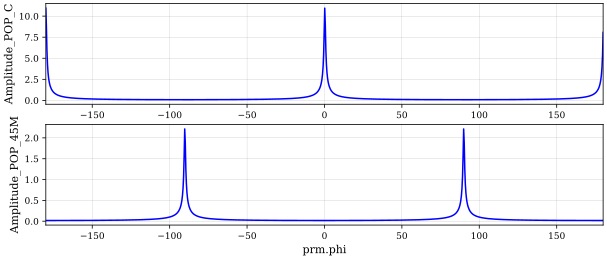

In [52]:
prmi.pr_Bs.L=pr_bs_l_opt
output=prmi.run()
Amp_POP_C=[]
Amp_POP_45M=[]
phi=np.linspace(-180,180,1000)
for i in range(1000):
    Amp_POP_C.append(abs(output["POP_C"][i]))
    Amp_POP_45M.append(abs(output["POP_45M"][i]))
import matplotlib.pyplot as plt
fig,plots=plt.subplots(2,figsize=(10,4))
plots[0].plot(phi,Amp_POP_C)
plots[0].set_ylabel("Amplitude_POP_C")
plots[1].plot(phi,Amp_POP_45M)
plots[1].set_ylabel("Amplitude_POP_45M")
plots[1].set_xlabel("prm.phi")

#### Now, the res of Sb and anti-res of C occur simultaneously.
#### To bring the necessary resonances to zero phase of xaxis, we will need to set the tuning phase.
#### For which, we will need to know the pr.phi at which the sideband attains a resonance, ideally it must be the angle I must give to bring the anti-resonance of carrier, which is 90 deg. But since the PRC length parameters are chosen randomly, these two do not match!
#### I am finding the pr.phi at which sideband attains resonance and tuning the PRM by that amount.
#### I am setting this angle and not 90 degrees because, I believe the Carrier need not be in a proper anti-resonance, It can be in a very close vicinity of it.

In [53]:
Amplitude=[]
pr_phi=np.linspace(0,180,500) #locating the fc+fm sideband.
for i in range(500,1000,1):
    Amplitude.append(abs(output["POP_45M"][i]))
max_amp=max(Amplitude)
pr_phi_opt=pr_phi[Amplitude.index(max_amp)]
print("pr_phi_opt:",pr_phi_opt) 

pr_phi_opt: 89.81963927855712


#### I am setting this optimum pr.phi.

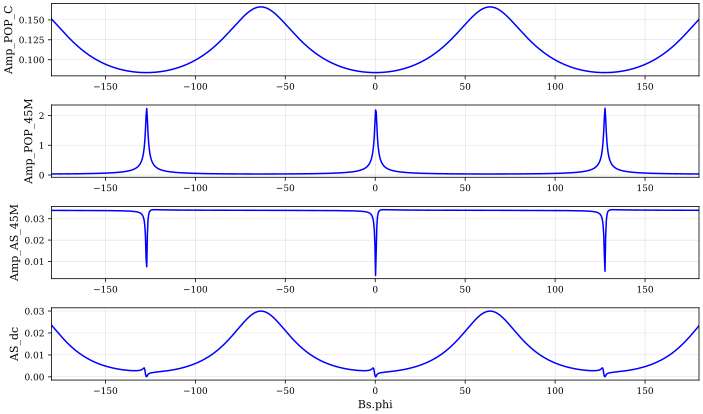

In [54]:
prmi.prm.phi=pr_phi_opt
prmi.parse("xaxis(Bs.phi,lin,-180,180,1000)")
output=prmi.run()
Amp_POP_C=[]
Amp_POP_45M=[]
Amp_AS_45M=[]
AS_dc=[]
phi=np.linspace(-180,180,1000)
for i in range(1000):
    Amp_POP_C.append(abs(output["POP_C"][i]))
    Amp_POP_45M.append(abs(output["POP_45M"][i]))
    Amp_AS_45M.append(abs(output["AS_45M"][i]))
    AS_dc.append(output["AS_dc"][i])
import matplotlib.pyplot as plt
fig,plots=plt.subplots(4,figsize=(10,6))
plots[0].plot(phi,Amp_POP_C)
plots[0].set_ylabel("Amp_POP_C")
plots[1].plot(phi,Amp_POP_45M)
plots[1].set_ylabel("Amp_POP_45M")
plots[2].plot(phi,Amp_AS_45M)
plots[2].set_ylabel("Amp_AS_45M")
plots[3].plot(phi,AS_dc)
plots[3].set_ylabel("AS_dc")
plots[3].set_xlabel("Bs.phi")
max_amp=max(Amp_AS_45M)
fig.tight_layout()

#### Res of SB and anti-res of C occur together at zero phase of the BS.
#### The DC readout at the AS port is zero, since it is dark for both C and SBs. We will need to set a Schnupp asymmetry to allow SB to AS port.
#### I will find the optimum Schnupp asymmetry that allows maximum SB transmission to the AS port. 

In [25]:
#del_f/f = del_l/l
prcl=pr_bs_l_opt+0.5*(lx+ly) #(michx+michy)/2
print(prcl)
f=3E8/1064E-9  
del_l=prcl*2*9E6/f #Schnupp asymmetry
print(del_l)

8.33366733466934
5.320213226452908e-07


In [63]:
prmi.parse("xaxis(Bs.phi,lin,-180,180,1000)") 
output=prmi.run()
#print("Recent katscript:\n",prmi.unparse())

0.16771930742614755


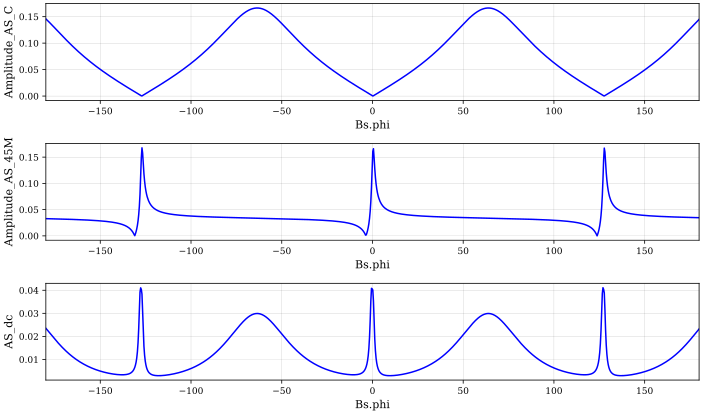

In [64]:
Amp_AS_C=[]
Amp_AS_45M=[]
AS_dc=[]
phi=np.linspace(-180,180,1000)
for i in range(1000):
    Amp_AS_C.append(abs(output["AS_C"][i]))
    Amp_AS_45M.append(abs(output["AS_45M"][i]))
    AS_dc.append(output["AS_dc"][i])
import matplotlib.pyplot as plt
fig,plots=plt.subplots(3,figsize=(10,6))
plots[0].plot(phi,Amp_AS_C)
plots[0].set_ylabel("Amplitude_AS_C")
plots[0].set_xlabel("Bs.phi")
plots[1].plot(phi,Amp_AS_45M)
plots[1].set_ylabel("Amplitude_AS_45M")
plots[1].set_xlabel("Bs.phi")
plots[2].plot(phi,AS_dc)
plots[2].set_ylabel("AS_dc")
plots[2].set_xlabel("Bs.phi")
fig.tight_layout()

max_amp_sb_AS=max(Amp_AS_45M)
print(max_amp_sb_AS) #finding the maximum possible Sb transmission to AS

4.44944944944945 m
Asymmetry for Max transmission: 0.050550550550550355 m


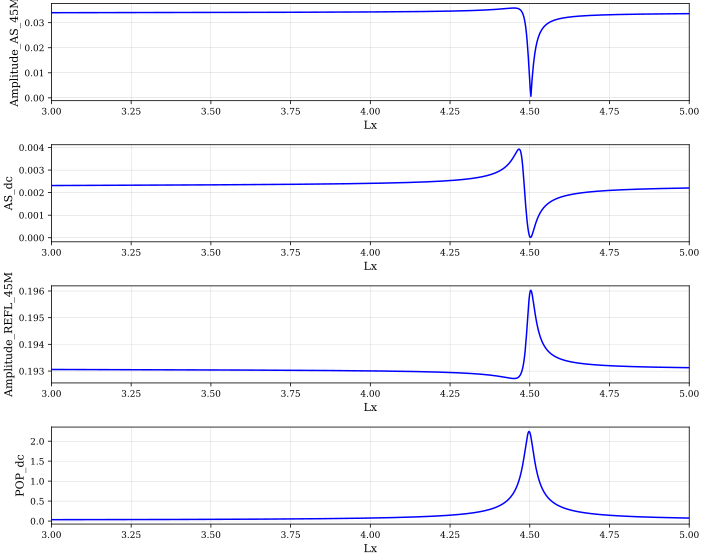

In [57]:
llim=3
ulim=5
Lx=np.linspace(llim,ulim,1000)
prmi.parse(f"xaxis(Lx.L,lin,{llim},{ulim},1000)")
output=prmi.run()
amp_AS_45M=[]
AS_dc=[]
amp_REFL_45M=[]
POP_dc=[]
for i in range(1000):
    AS_dc.append(output["AS_dc"][i])
    amp_AS_45M.append(abs(output["AS_45M"][i]))
    amp_REFL_45M.append(abs(output["REFL_45M"][i]))
    POP_dc.append(abs(output["POP_45M"][i]))
fig,plots=plt.subplots(4,figsize=(10,8))
plots[0].plot(Lx,amp_AS_45M)
plots[0].set_ylabel("Amplitude_AS_45M")
plots[0].set_xlabel("Lx")
plots[1].plot(Lx,AS_dc)
plots[1].set_ylabel("AS_dc")
plots[1].set_xlabel("Lx")
plots[2].plot(Lx,amp_REFL_45M)
plots[2].set_ylabel("Amplitude_REFL_45M")
plots[2].set_xlabel("Lx")
plots[3].plot(Lx,POP_dc)
plots[3].set_ylabel("POP_dc")
plots[3].set_xlabel("Lx")
fig.tight_layout()
print(Lx[amp_AS_45M.index(max(amp_AS_45M))],"m")
Schnupp=lx-Lx[amp_AS_45M.index(max(amp_AS_45M))]
print("Asymmetry for Max transmission:",Schnupp,"m")

0.16771930742614755


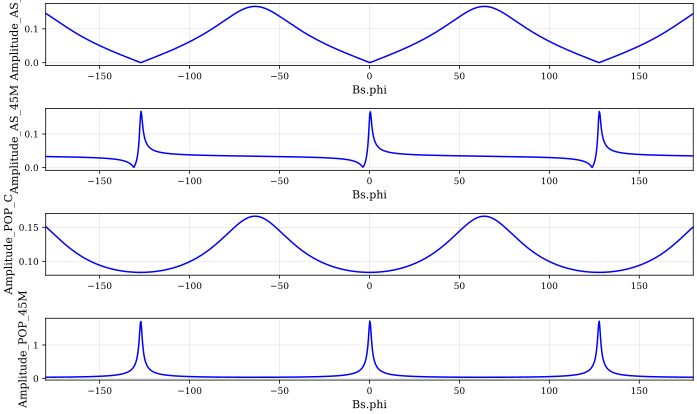

In [66]:
prmi.Lx.L=4.5+Schnupp
prmi.Ly.L=4.5-Schnupp
prmi.parse("xaxis(Bs.phi,lin,-180,180,1000)") 
output=prmi.run()
Amp_AS_C=[]
Amp_AS_45M=[]
Amp_POP_C=[]
Amp_POP_45M=[]
phi=np.linspace(-180,180,1000)
for i in range(1000):
    Amp_AS_C.append(abs(output["AS_C"][i]))
    Amp_AS_45M.append(abs(output["AS_45M"][i]))
    Amp_POP_C.append(abs(output["POP_C"][i]))
    Amp_POP_45M.append(abs(output["POP_45M"][i]))
import matplotlib.pyplot as plt
fig,plots=plt.subplots(4,figsize=(10,6))
plots[0].plot(phi,Amp_AS_C)
plots[0].set_ylabel("Amplitude_AS_C")
plots[0].set_xlabel("Bs.phi")
plots[1].plot(phi,Amp_AS_45M)
plots[1].set_ylabel("Amplitude_AS_45M")
plots[1].set_xlabel("Bs.phi")
plots[2].plot(phi,Amp_POP_C)
plots[2].set_ylabel("Amplitude_POP_C")
plots[3].plot(phi,Amp_POP_45M)
plots[3].set_ylabel("Amplitude_POP_45M")
plots[3].set_xlabel("Bs.phi")
fig.tight_layout()

max_amp_sb_AS=max(Amp_AS_45M)
print(max_amp_sb_AS) #finding the maximum possible Sb transmission to AS